In [1]:
import os
import sys

# os.chdir('../')
sys.path.append(os.getcwd())

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from scipy.stats import fisher_exact, chi2_contingency
from sklearn.manifold import TSNE, MDS
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, PrecisionRecallDisplay
from multipy.fwer import sidak, hochberg
from xgboost import XGBClassifier
import random

from utils.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_generated_to_real_distribution, \
                            plot_olga_cleanup_data, plot_clusters_of_clonotypes, plot_cooccurence_heatmap_with_epitopes_labeling, plot_waterfall_by_column, \
                            plot_feature_importances, plot_volcano, plot_clonotype_clustering_with_epitope_labeling
from utils.ml_utils import get_parameters, prepare_data, evaluate_models, split_data_by_batch, cross_validation_between_batches, make_hla_predictor
from utils.data_utils import prepare_run_column
from utils.stats_utils import evaluate_anova_testing, evaluate_mannwhitneyu_testing, get_top_changed_clonotypes
from utils.clustering_utils import seqs2hamming, check_significant_epitopes_for_cluster, get_most_frequent_cluster_by_vdjdb_occurence
from utils.weblogo_utils import create_web_logo
from source.alpha_beta_paired_clones_search import make_metaclone_cm


import warnings
warnings.filterwarnings('ignore')


import importlib
imported_module = importlib.import_module("utils.stats_utils")
importlib.reload(imported_module)

/home/evlasova/tcr-covid-classifier


<module 'utils.stats_utils' from '/home/evlasova/tcr-covid-classifier/utils/stats_utils.py'>

# Reading UMs

In [2]:
norm_um_joint = pd.read_csv('data/normalized_usage_matrix_joint.csv').drop(columns=['Unnamed: 0']).fillna(0)
stand_um_joint = pd.read_csv('data/standardized_usage_matrix_joint.csv').drop(columns=['Unnamed: 0']).fillna(0)

In [3]:
norm_um_joint['project'] = norm_um_joint['project'].apply(lambda x: x.replace('_DNA', '').split('_')[-1])

In [4]:
stand_um_joint['project'] = stand_um_joint['project'].apply(lambda x: x.replace('_DNA', '').split('_')[-1])

In [5]:
stand_um_joint

,run,project,covid,TRBV4-3,TRBV12-3,TRBV5-1,TRBV7-5,TRBV6-1,TRBV6-3,TRBV6-8,...,TRBV12-2,TRBV21-1,TRBV6-4,TRBV25-1,TRBV12-1,TRBV26,TRBV1,TRBV5-2,TRBV22-1,TRBV8-2
0,020000010808_S3_L001.clonotypes.TRB.txt,NovaSeq5,covid,0.007480,0.016990,0.098765,0.000842,0.041145,0.014504,0.001215,...,0.001189,0.012874,0.010171,0.009564,0.001845,7.829635e-07,0.001221,0.000003,0.000010,1.919988e-06
1,020000190808_S27_L001.clonotypes.TRB.txt,NovaSeq5,covid,0.016034,0.016482,0.030225,0.001092,0.010377,0.032557,0.001068,...,0.002931,0.025701,0.014223,0.013660,0.000677,7.829635e-07,0.001221,0.000003,0.000010,1.919988e-06
2,020000200808_S181_L002.clonotypes.TRB.txt,NovaSeq5,healthy,0.016211,0.015015,0.055529,0.001449,0.026552,0.014504,0.000673,...,0.001900,0.012949,0.012296,0.003256,0.001608,7.829635e-07,0.001221,0.000003,0.000010,1.919988e-06
3,020000280808_S59_L001.clonotypes.TRB.txt,NovaSeq5,covid,0.016165,0.011231,0.038502,0.000918,0.029301,0.014504,0.000991,...,0.002518,0.009758,0.004701,0.004156,0.001164,7.829635e-07,0.001221,0.000003,0.000010,1.919988e-06
4,020000340808_S82_L001.clonotypes.TRB.txt,NovaSeq5,covid,0.001564,0.011048,0.088015,0.000990,0.027020,0.014504,0.001106,...,0.002694,0.017370,0.014105,0.008714,0.000359,7.829635e-07,0.001221,0.000003,0.000010,1.919988e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2942,Keck0116_MC1.txt,KECK,healthy,0.015809,0.013650,0.046496,0.000465,0.022938,0.018778,0.000796,...,0.003201,0.012373,0.002358,0.005772,0.001048,6.518806e-07,0.001866,0.000003,0.000008,1.472114e-06
2943,Keck0117_MC1.txt,KECK,healthy,0.016538,0.013650,0.048885,0.001016,0.012511,0.017429,0.000951,...,0.001798,0.013920,0.013441,0.006388,0.001086,7.248830e-07,0.001227,0.000001,0.000006,1.641770e-06
2944,Keck0118_MC1.txt,KECK,healthy,0.017103,0.013650,0.036634,0.000887,0.010914,0.025931,0.001205,...,0.001709,0.010515,0.015801,0.012143,0.000606,6.773039e-07,0.001454,0.000004,0.000007,1.984430e-06
2945,Keck0119_MC1.txt,KECK,healthy,0.004354,0.013650,0.080438,0.000275,0.024899,0.005967,0.000225,...,0.001475,0.009334,0.001949,0.015546,0.000788,6.616699e-07,0.001133,0.000004,0.000011,6.833079e-07


# Analysis of Adaptive found biomarkers

In [6]:
all_adaptive_cm = pd.read_csv('data/sign_clone_matrix_joint_adaptive_based.csv').drop(columns=['Unnamed: 0'])

In [7]:
all_adaptive_cm.head()

,CASSLAGGTDTQYF,CASSLAGTDTQYF,CASSLGYGYTF,CASSLGQGNYGYTF,CASSLEGYGYTF,CASSLKETQYF,CASSLGGQETQYF,CASSLGQGNSPLHF,CASSLQGNYGYTF,CASSPDSNYGYTF,...,CASSQGTRGGYTF,CASSQEYRNYGYTF,CASSQDRGASPLHF,CASSYSVYSNQPQHF,CASSQVSGGSPLHF,CASSLVGKNQPQHF,CASSLRSGGNSPLHF,CASSQVPYNSPLHF,CASSSGFGNSPLHF,run
0,0,1,0,0,0,2,1,1,2,1,...,0,0,0,0,0,0,0,0,0,020000010808_S3_L001.clonotypes.TRB.txt
1,0,3,2,3,1,2,0,1,3,0,...,0,0,0,0,0,0,0,0,0,140003810101_S56_L001.clonotypes.TRB.txt
2,0,1,2,0,2,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,540002820808_S93_L001.clonotypes.TRB.txt
3,0,0,2,3,2,0,0,2,2,2,...,0,0,0,0,0,0,0,0,0,050000200808_S157_L002.clonotypes.TRB.txt
4,0,0,0,0,2,2,2,1,0,0,...,0,0,0,0,0,0,0,0,0,540002380807_S103_L002.clonotypes.TRB.txt


In [8]:
fold_change_data_adaptive = get_top_changed_clonotypes(clonotype_matrix=all_adaptive_cm[~all_adaptive_cm.run.str.contains('clonotypes')],
                           desc=stand_um_joint, 
                           pvals=pd.read_csv('data/covid_significant_clone_pvals_adaptive.csv').drop(columns=['Unnamed: 0']), 
                           run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_joint.csv'),
                           healthy_col='covid', 
                           healthy_label='healthy')
fold_change_data_adaptive

v


,clone,pval,count_of_ways_h,count_of_ways_i,fold_change,log_fold_change
0,CASSLAGGTDTQYF,2.147232e-36,0.037734,0.079626,2.110162,1.077353
1,CASSLAGTDTQYF,4.580624e-17,0.040978,0.078532,1.916454,0.938439
2,CASSLGYGYTF,9.242666e-17,0.038171,0.068974,1.806967,0.853570
3,CASSLGQGNYGYTF,1.563491e-88,0.031822,0.078880,2.478774,1.309627
4,CASSLEGYGYTF,5.863973e-18,0.036900,0.070765,1.917761,0.939423
...,...,...,...,...,...,...
27786,CASSQVSGGSPLHF,2.701489e-17,0.000309,0.000971,3.137389,1.649564
27787,CASSLVGKNQPQHF,1.778443e-25,0.003093,0.009412,3.043454,1.605710
27788,CASSLRSGGNSPLHF,6.249292e-28,0.000740,0.004224,5.708928,2.513220
27789,CASSQVPYNSPLHF,1.757291e-18,0.000360,0.001986,5.515545,2.463504


In [9]:
fold_change_data_adaptive[fold_change_data_adaptive.log_fold_change > 2.25]

,clone,pval,count_of_ways_h,count_of_ways_i,fold_change,log_fold_change
482,CASSYSGLAGVYNEQFF,6.456909e-74,0.000479,0.007314,15.276951,3.933285
834,CASSQDLGQPQHF,2.798538e-131,0.003438,0.018130,5.273596,2.398787
860,CASSAGPYNSPLHF,1.153564e-62,0.001629,0.007930,4.869587,2.283799
911,CSARSGHEQYF,5.589940e-120,0.001547,0.015128,9.777517,3.289468
1413,CASSQDLGNTEAFF,8.304220e-99,0.002934,0.015125,5.155370,2.366076
...,...,...,...,...,...,...
27783,CASSQEYRNYGYTF,4.882385e-24,0.000164,0.001741,10.634155,3.410634
27784,CASSQDRGASPLHF,1.032035e-30,0.000709,0.004235,5.975068,2.578955
27785,CASSYSVYSNQPQHF,5.666527e-20,0.000505,0.003130,6.201422,2.632599
27788,CASSLRSGGNSPLHF,6.249292e-28,0.000740,0.004224,5.708928,2.513220


In [10]:
selected_clones = fold_change_data_adaptive[fold_change_data_adaptive.log_fold_change > 2.25].clone

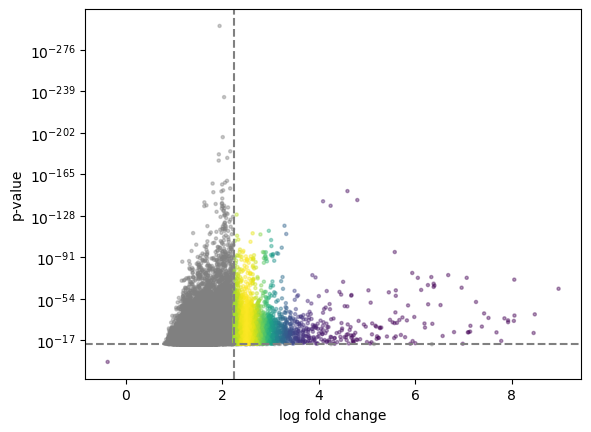

In [11]:
plot_volcano(fold_change_data_adaptive, pval_threshold=1e-14, fold_change_threshold=2.25)

In [12]:
selected_clones.shape

(3186,)

In [166]:
all_adaptive_cm[['run'] + list(selected_clones)].to_csv('data/sign_clone_matrix_fold_change_adaptive.csv')

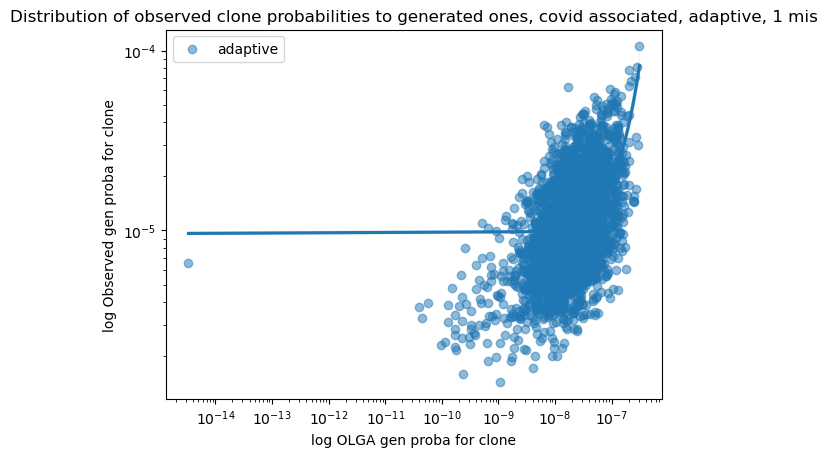

In [54]:
probas_adaptive = plot_generated_to_real_distribution(pgen_paths=['data/covid_adaptive_pgen.csv'], 
                                    cm_paths=['data/sign_clone_matrix_fold_change.csv'], 
                                    desc='covid associated, adaptive, 1 mis', 
                                    run_to_number_of_clones_path='data/run_to_number_of_clones_adaptive.csv', 
                                    labels=['adaptive'],
                                    make_bool_features=False)['adaptive']

In [47]:
vdjdb = pd.read_csv('data/vdjdb.txt', sep='\t')

In [48]:
res_adaptive = seqs2hamming(selected_clones, threshold=1, viz_method='drl')

In [49]:
res_adaptive

,cdr3,cluster,x,y,cluster_size,x_mean,y_mean
0,CASSYSGLAGVYNEQFF,0,-200.729950,-149.440964,37,-206.757370,-164.383672
1,CASSYSGLAGIYNEQFF,0,-200.476654,-148.832245,37,-206.757370,-164.383672
2,CASSYSPLAGVYNEQFF,0,-202.833572,-155.246063,37,-206.757370,-164.383672
3,CASSYSGLAGAYNEQFF,0,-200.255020,-148.116119,37,-206.757370,-164.383672
4,CASSYSGLAGLYNEQFF,0,-200.569290,-148.482803,37,-206.757370,-164.383672
...,...,...,...,...,...,...,...
3181,CASSLVQGENSPLHF,275,419.977570,309.620239,1,419.977570,309.620239
3182,CASSQGGGVGYTF,276,-329.798370,-311.201019,1,-329.798370,-311.201019
3183,CASSQVQGADGYTF,277,-182.916077,-425.625183,1,-182.916077,-425.625183
3184,CASSQEDRGETQYF,278,455.174530,-119.650337,1,455.174530,-119.650337


In [50]:
adaptive_cluster_to_epi = {}
for cluster_index in range(res_adaptive.cluster.max() + 1):
    adaptive_cluster_to_epi[cluster_index] = check_significant_epitopes_for_cluster(vdjdb, res_adaptive, cluster_index, dist=1, gene='TRB')

# Making FMBA based classifier

In [13]:
fmba_not_nan_hla = pd.read_csv('data/desc_fmba_not_nan_hla.csv')

In [14]:
fmba_not_nan_hla = fmba_not_nan_hla[fmba_not_nan_hla.COVID_status != 'unknown']

In [15]:
good_fmba_samples = fmba_not_nan_hla.run

In [16]:
good_fmba_samples

0        020000010808_S3_L001.clonotypes.TRB.txt
1       020000110808_S14_L001.clonotypes.TRB.txt
2       020000190808_S27_L001.clonotypes.TRB.txt
3      020000200808_S181_L002.clonotypes.TRB.txt
4       020000280808_S59_L001.clonotypes.TRB.txt
                         ...                    
951    780008510808_S152_L002.clonotypes.TRB.txt
952    780008550808_S150_L002.clonotypes.TRB.txt
953    910000140808_S123_L002.clonotypes.TRB.txt
954    910000320808_S121_L002.clonotypes.TRB.txt
955    910003810808_S120_L002.clonotypes.TRB.txt
Name: run, Length: 956, dtype: object

In [17]:
stand_um_joint['platform'] = stand_um_joint.run.apply(lambda x: 'fmba' if 'TRB' in x else 'adaptive')

In [18]:
stand_um_joint['platform'].value_counts()

adaptive    1991
fmba         956
Name: platform, dtype: int64

In [19]:
data_fmba = prepare_data(run_to_number_of_clones_path = 'data/run_to_number_of_clones_joint.csv',
                 desc_path='data/standardized_usage_matrix_joint.csv',
                 clonotype_matrix_path='data/sign_clone_matrix_joint_fmba_based.csv',
                 hla_keys_path=None,
                 make_freq=True,
                 use_hla_clones=False,
                 use_hla_bool=False,
                 make_all_features_bool=True,
                 use_standardization=True,
                 raw_target_column='covid',
                 raw_target_clumn_success_label='covid',
                 final_target_column='covid',
                 metadata_columns=[])
fmba_good_beta_biomarkers_data = [x for x in pd.read_csv('data/sign_clone_matrix_joint_fmba_based.csv').columns if x.startswith('CAS')]
data_fmba = data_fmba[fmba_good_beta_biomarkers_data + ['covid']]
data_fmba['folder'] = stand_um_joint['project']
data_fmba['platform'] = stand_um_joint['platform']
data_fmba['run'] = stand_um_joint['run']

In [20]:
data_fmba = data_fmba[(data_fmba.run.isin(good_fmba_samples)) | (data_fmba.platform == 'adaptive')].drop(columns=['run', 'platform'])

In [21]:
data_fmba

,CASARGYEQYF,CASDRGYEQYF,CASGLGGNQPQHF,CASGLGGSYEQYF,CASGLSGGNQPQHF,CASMRGYEQYF,CASNLGGSYEQYF,CASRDAYEQYF,CASRGGPYEQYF,CASRPGGSYEQYF,...,CASSYGGSYEQYF,CASSYGQGYEQYF,CASSYGSYEQYF,CASSYGTGSYEQYF,CASSYGTTYEQYF,CASSYGYEQYF,CASSYSYEQYF,CASWRGYEQYF,covid,folder
0,-1.594386,-1.56939,-2.209578,-1.733227,0.906303,-1.561646,-1.585091,-1.594386,-1.684411,0.552392,...,-2.987065,0.339147,0.292320,-2.759884,-1.848862,-5.031153,0.165968,-1.520275,1,NovaSeq5
1,-1.594386,-1.56939,-2.209578,-1.733227,0.906303,-1.561646,-1.585091,0.627201,-1.684411,-1.810308,...,0.334777,0.339147,-3.420904,0.362334,0.540873,0.198762,0.165968,-1.520275,1,NovaSeq5
2,-1.594386,-1.56939,0.452575,-1.733227,-1.103384,-1.561646,-1.585091,-1.594386,-1.684411,-1.810308,...,0.334777,0.339147,0.292320,0.362334,0.540873,0.198762,0.165968,-1.520275,0,NovaSeq5
3,0.627201,0.63719,-2.209578,-1.733227,0.906303,0.640350,-1.585091,0.627201,-1.684411,-1.810308,...,0.334777,0.339147,-3.420904,0.362334,-1.848862,0.198762,-6.025263,0.657776,1,NovaSeq5
4,-1.594386,-1.56939,-2.209578,-1.733227,-1.103384,-1.561646,-1.585091,-1.594386,-1.684411,-1.810308,...,0.334777,-2.948572,0.292320,-2.759884,-1.848862,0.198762,0.165968,-1.520275,1,NovaSeq5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2942,0.627201,0.63719,0.452575,0.576958,0.906303,0.640350,0.630878,0.627201,0.593679,0.552392,...,0.334777,0.339147,0.292320,0.362334,0.540873,0.198762,0.165968,0.657776,0,KECK
2943,0.627201,0.63719,0.452575,0.576958,0.906303,0.640350,0.630878,0.627201,0.593679,0.552392,...,0.334777,0.339147,0.292320,0.362334,0.540873,0.198762,0.165968,0.657776,0,KECK
2944,0.627201,0.63719,0.452575,0.576958,-1.103384,0.640350,0.630878,0.627201,0.593679,0.552392,...,0.334777,0.339147,0.292320,0.362334,0.540873,0.198762,0.165968,0.657776,0,KECK
2945,0.627201,0.63719,0.452575,0.576958,0.906303,0.640350,0.630878,0.627201,0.593679,0.552392,...,0.334777,0.339147,0.292320,0.362334,0.540873,0.198762,0.165968,0.657776,0,KECK


In [22]:
X_train_fmba, y_train_fmba, X_test_fmba, y_test_fmba = split_data_by_batch(data=data_fmba, 
                                                       test_batches=[x for x in stand_um_joint.project.unique() if 'Nova' not in x], 
                                                       y_column='covid', 
                                                       batch_column='folder')

In [23]:
fmba_clf = SVC(C=5, kernel='rbf', probability=True, random_state=42).fit(X_train_fmba, y_train_fmba)

In [24]:
y_pred_fmba = fmba_clf.predict(X_test_fmba)

In [25]:
metrics_fmba = pd.DataFrame({'f1': [round(f1_score(y_test_fmba, y_pred_fmba), 2)], 
              'precision': [round(precision_score(y_test_fmba, y_pred_fmba), 2)], 
              'recall': [round(recall_score(y_test_fmba, y_pred_fmba), 2)]})

In [26]:
fmba_cm = pd.read_csv('data/sign_clone_matrix_joint_fmba_based.csv').drop(columns=['Unnamed: 0'])
fmba_clones = fmba_cm.drop(columns=['run']).columns
res_fmba = seqs2hamming(fmba_clones, threshold=1, viz_method='drl')
metaclone_fmba_cm = make_metaclone_cm(fmba_cm, res_fmba)
metaclone_fmba_cm.to_csv('data/clone_matrix_covid_fmba_and_adaptive_metaclone.csv')

In [27]:
data_fmba_meta = prepare_data(run_to_number_of_clones_path = 'data/run_to_number_of_clones_joint.csv',
                 desc_path='data/standardized_usage_matrix_joint.csv',
                 clonotype_matrix_path='data/clone_matrix_covid_fmba_and_adaptive_metaclone.csv',
                 hla_keys_path=None,
                 make_freq=True,
                 use_hla_clones=False,
                 use_hla_bool=False,
                 make_all_features_bool=True,
                 use_standardization=True,
                 raw_target_column='covid',
                 raw_target_clumn_success_label='covid',
                 final_target_column='covid',
                 metadata_columns=[])
data_fmba_meta['folder'] = stand_um_joint['project']
data_fmba_meta['platform'] = stand_um_joint['platform']
data_fmba_meta['run'] = stand_um_joint['run']

In [28]:
X_train_fmba_m, y_train_fmba_m, X_test_fmba_m, y_test_fmba_m = split_data_by_batch(data=data_fmba_meta.drop(columns=['run', 'platform']), 
                                                       test_batches=[x for x in stand_um_joint.project.unique() if 'Nova' not in x], 
                                                       y_column='covid', 
                                                       batch_column='folder')

In [29]:
fmba_clf_m = SVC(C=5, kernel='rbf', probability=True, random_state=42).fit(X_train_fmba_m, y_train_fmba_m)
y_pred_fmba_m = fmba_clf_m.predict(X_test_fmba_m)

In [30]:
metrics_fmba_m = pd.DataFrame({'f1': [round(f1_score(y_test_fmba_m, y_pred_fmba_m), 2)], 
              'precision': [round(precision_score(y_test_fmba_m, y_pred_fmba_m), 2)], 
              'recall': [round(recall_score(y_test_fmba_m, y_pred_fmba_m), 2)]})

# Making Adaptive based classifier

In [31]:
data_adaptive = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clones_joint_50k.csv',
             desc_path='data/standardized_usage_matrix_joint.csv',
             clonotype_matrix_path='data/sign_clone_matrix_fold_change_adaptive.csv',
             hla_keys_path=None,
             make_freq=True,
             use_hla_clones=False,
             use_hla_bool=False,
             use_standardization=True,
             raw_target_column='covid',
             raw_target_clumn_success_label='covid',
             final_target_column='covid',
             metadata_columns=[])

data_adaptive['folder'] = stand_um_joint['project']
data_adaptive['platform'] = stand_um_joint['platform']
data_adaptive['run'] = stand_um_joint['run']

In [32]:
data_adaptive = data_adaptive[(data_adaptive.run.isin(good_fmba_samples)) | (data_adaptive.platform == 'adaptive')].drop(columns=['run', 'platform'])

In [33]:
X_train_adaptive, y_train_adaptive, X_test_adaptive, y_test_adaptive = split_data_by_batch(data=data_adaptive, 
                                                                           test_batches=[x for x in stand_um_joint.project.unique() if 'Nova' in x], 
                                                                           y_column='covid', 
                                                                           batch_column='folder')

In [34]:
adaptive_clf = SVC(C=5, kernel='rbf', probability=True, random_state=42).fit(X_train_adaptive, y_train_adaptive)

In [35]:
y_pred_adaptive = adaptive_clf.predict(X_test_adaptive)

In [36]:
metrics_adaptive = pd.DataFrame({'f1': [round(f1_score(y_test_adaptive, y_pred_adaptive), 2)], 
              'precision': [round(precision_score(y_test_adaptive, y_pred_adaptive), 2)], 
              'recall': [round(recall_score(y_test_adaptive, y_pred_adaptive), 2)]})

In [37]:
adaptive_cm = pd.read_csv('data/sign_clone_matrix_fold_change_adaptive.csv').drop(columns=['Unnamed: 0'])
adaptive_clones = adaptive_cm.drop(columns=['run']).columns
res_adaptive = seqs2hamming(adaptive_clones, threshold=1, viz_method='drl')
metaclone_adaptive_cm = make_metaclone_cm(adaptive_cm, res_adaptive)
metaclone_adaptive_cm.to_csv('data/clone_matrix_covid_fmba_and_adaptive_metaclone_adaptive_based.csv')

data_adaptive_meta = prepare_data(run_to_number_of_clones_path = 'data/run_to_number_of_clones_joint_50k.csv',
                 desc_path='data/standardized_usage_matrix_joint.csv',
                 clonotype_matrix_path='data/clone_matrix_covid_fmba_and_adaptive_metaclone_adaptive_based.csv',
                 hla_keys_path=None,
                 make_freq=True,
                 use_hla_clones=False,
                 use_hla_bool=False,
                 use_standardization=True,
                 raw_target_column='covid',
                 raw_target_clumn_success_label='covid',
                 final_target_column='covid',
                 metadata_columns=[])
data_adaptive_meta['folder'] = stand_um_joint['project']
data_adaptive_meta['platform'] = stand_um_joint['platform']
data_adaptive_meta['run'] = stand_um_joint['run']

X_train_adaptive_m, y_train_adaptive_m, X_test_adaptive_m, y_test_adaptive_m = split_data_by_batch(
                                                       data=data_adaptive_meta.drop(columns=['run', 'platform']), 
                                                       test_batches=[x for x in stand_um_joint.project.unique() if 'Nova' in x], 
                                                       y_column='covid', 
                                                       batch_column='folder')

adaptive_clf_m = SVC(C=5, kernel='rbf', probability=True, random_state=42).fit(X_train_adaptive_m, y_train_adaptive_m)
y_pred_adaptive_m = adaptive_clf_m.predict(X_test_adaptive_m)

metrics_adaptive_m = pd.DataFrame({'f1': [round(f1_score(y_test_adaptive_m, y_pred_adaptive_m), 2)], 
              'precision': [round(precision_score(y_test_adaptive_m, y_pred_adaptive_m), 2)], 
              'recall': [round(recall_score(y_test_adaptive_m, y_pred_adaptive_m), 2)]})

# Making joint df for metrics

In [38]:
y_test_data = {
    'fmba->adaptive': y_test_fmba,
    'adaptive->fmba': y_test_adaptive,
    # 'fmba_meta->adaptive': y_test_fmba_m,
    # 'adaptive_meta->fmba': y_test_adaptive_m,
} 
all_clfs = {
    'fmba->adaptive': fmba_clf,
    'adaptive->fmba': adaptive_clf,
    # 'fmba_meta->adaptive': fmba_clf_m,
    # 'adaptive_meta->fmba': adaptive_clf_m
} 
X_test_data = {
    'fmba->adaptive': X_test_fmba,
    'adaptive->fmba': X_test_adaptive,
    # 'fmba_meta->adaptive': X_test_fmba_m,
    # 'adaptive_meta->fmba': X_test_adaptive_m
} 

In [39]:
metrics = pd.concat([metrics_fmba, metrics_adaptive])
metrics.index = ['fmba->adaptive', 'adaptive->fmba']

In [40]:
metrics

,f1,precision,recall
fmba->adaptive,0.76,0.61,1.0
adaptive->fmba,0.82,0.69,1.0


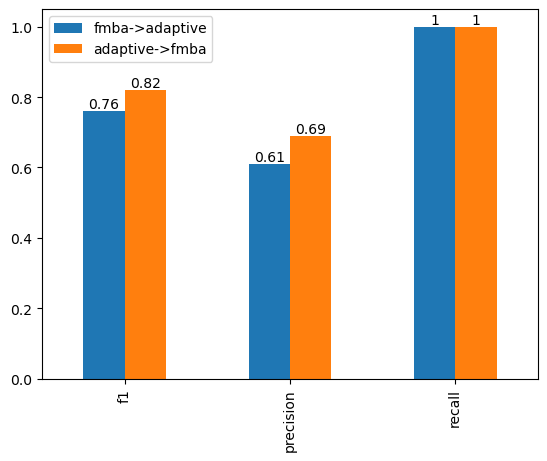

In [41]:
fig, ax = plt.subplots()
metrics.T.plot.bar(ax=ax)
for c in ax.containers:
    ax.bar_label(c, label_type='edge')

# Making joint clustering results

In [42]:
covid_clones_fmba_beta = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRB_top_500k_wo_leaks.csv').drop(columns=['Unnamed: 0']).columns[1:]

In [62]:
res_joint = seqs2hamming(list(selected_clones) + list(covid_clones_fmba_beta), threshold=1, viz_method='drl')

In [63]:
res_joint['platform'] = res_joint.cdr3.apply(lambda x: 'joint' if x in covid_clones_fmba_beta and x in selected_clones else ('fmba' if x in covid_clones_fmba_beta else 'adaptive'))

In [59]:
res_joint

,cdr3,cluster,x,y,cluster_size,x_mean,y_mean,platform
0,CASSYSGLAGVYNEQFF,0,468.912505,481.106635,37,585.526369,40.415961,adaptive
1,CASSYSGLAGIYNEQFF,0,483.756763,496.601364,37,585.526369,40.415961,adaptive
2,CASSYSPLAGVYNEQFF,0,505.676131,312.669870,37,585.526369,40.415961,adaptive
3,CASSYSGLAGAYNEQFF,0,462.889162,512.565745,37,585.526369,40.415961,adaptive
4,CASSYSGLAGLYNEQFF,0,466.322996,495.749130,37,585.526369,40.415961,adaptive
...,...,...,...,...,...,...,...,...
3697,CSARTSYEQYF,331,463.491666,-758.490560,5,476.110222,-754.371789,fmba
3698,CSASDRGYEQYF,332,-802.348261,-233.012793,1,-802.348261,-233.012793,fmba
3699,CSASDSYEQYF,333,-671.825393,642.422216,1,-671.825393,642.422216,fmba
3700,CSASGGGYEQYF,334,-810.698910,-372.013964,1,-810.698910,-372.013964,fmba


In [60]:
joint_cluster_to_epi = {}
for cluster_index in range(res_joint.cluster.max() + 1):
    joint_cluster_to_epi[cluster_index] = check_significant_epitopes_for_cluster(vdjdb, res_joint, cluster_index, dist=1, gene='TRB')

(-900.0, 900.0)

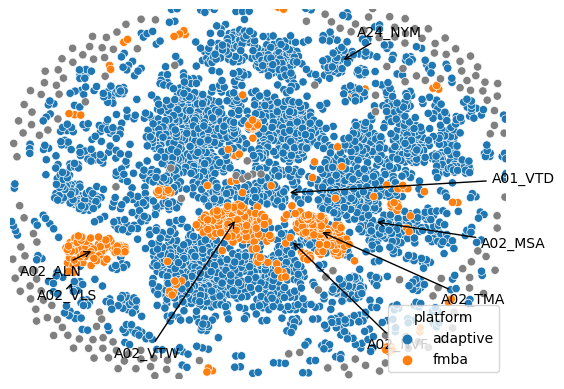

In [61]:
fig, ax = plt.subplots()
plot_clonotype_clustering_with_epitope_labeling(res_joint, 
                                                joint_cluster_to_epi, 
                                                vdjdb, 
                                                gene='TRB',
                                                color_by='platform',
                                                cluster_size_threshold=0, 
                                                dist_to_center=850, 
                                                center_diff_threshold=75,
                                                ax=ax)
ax.set_xlim(-900, 900)
ax.set_ylim(-900, 900)


# Plotting Fig 5

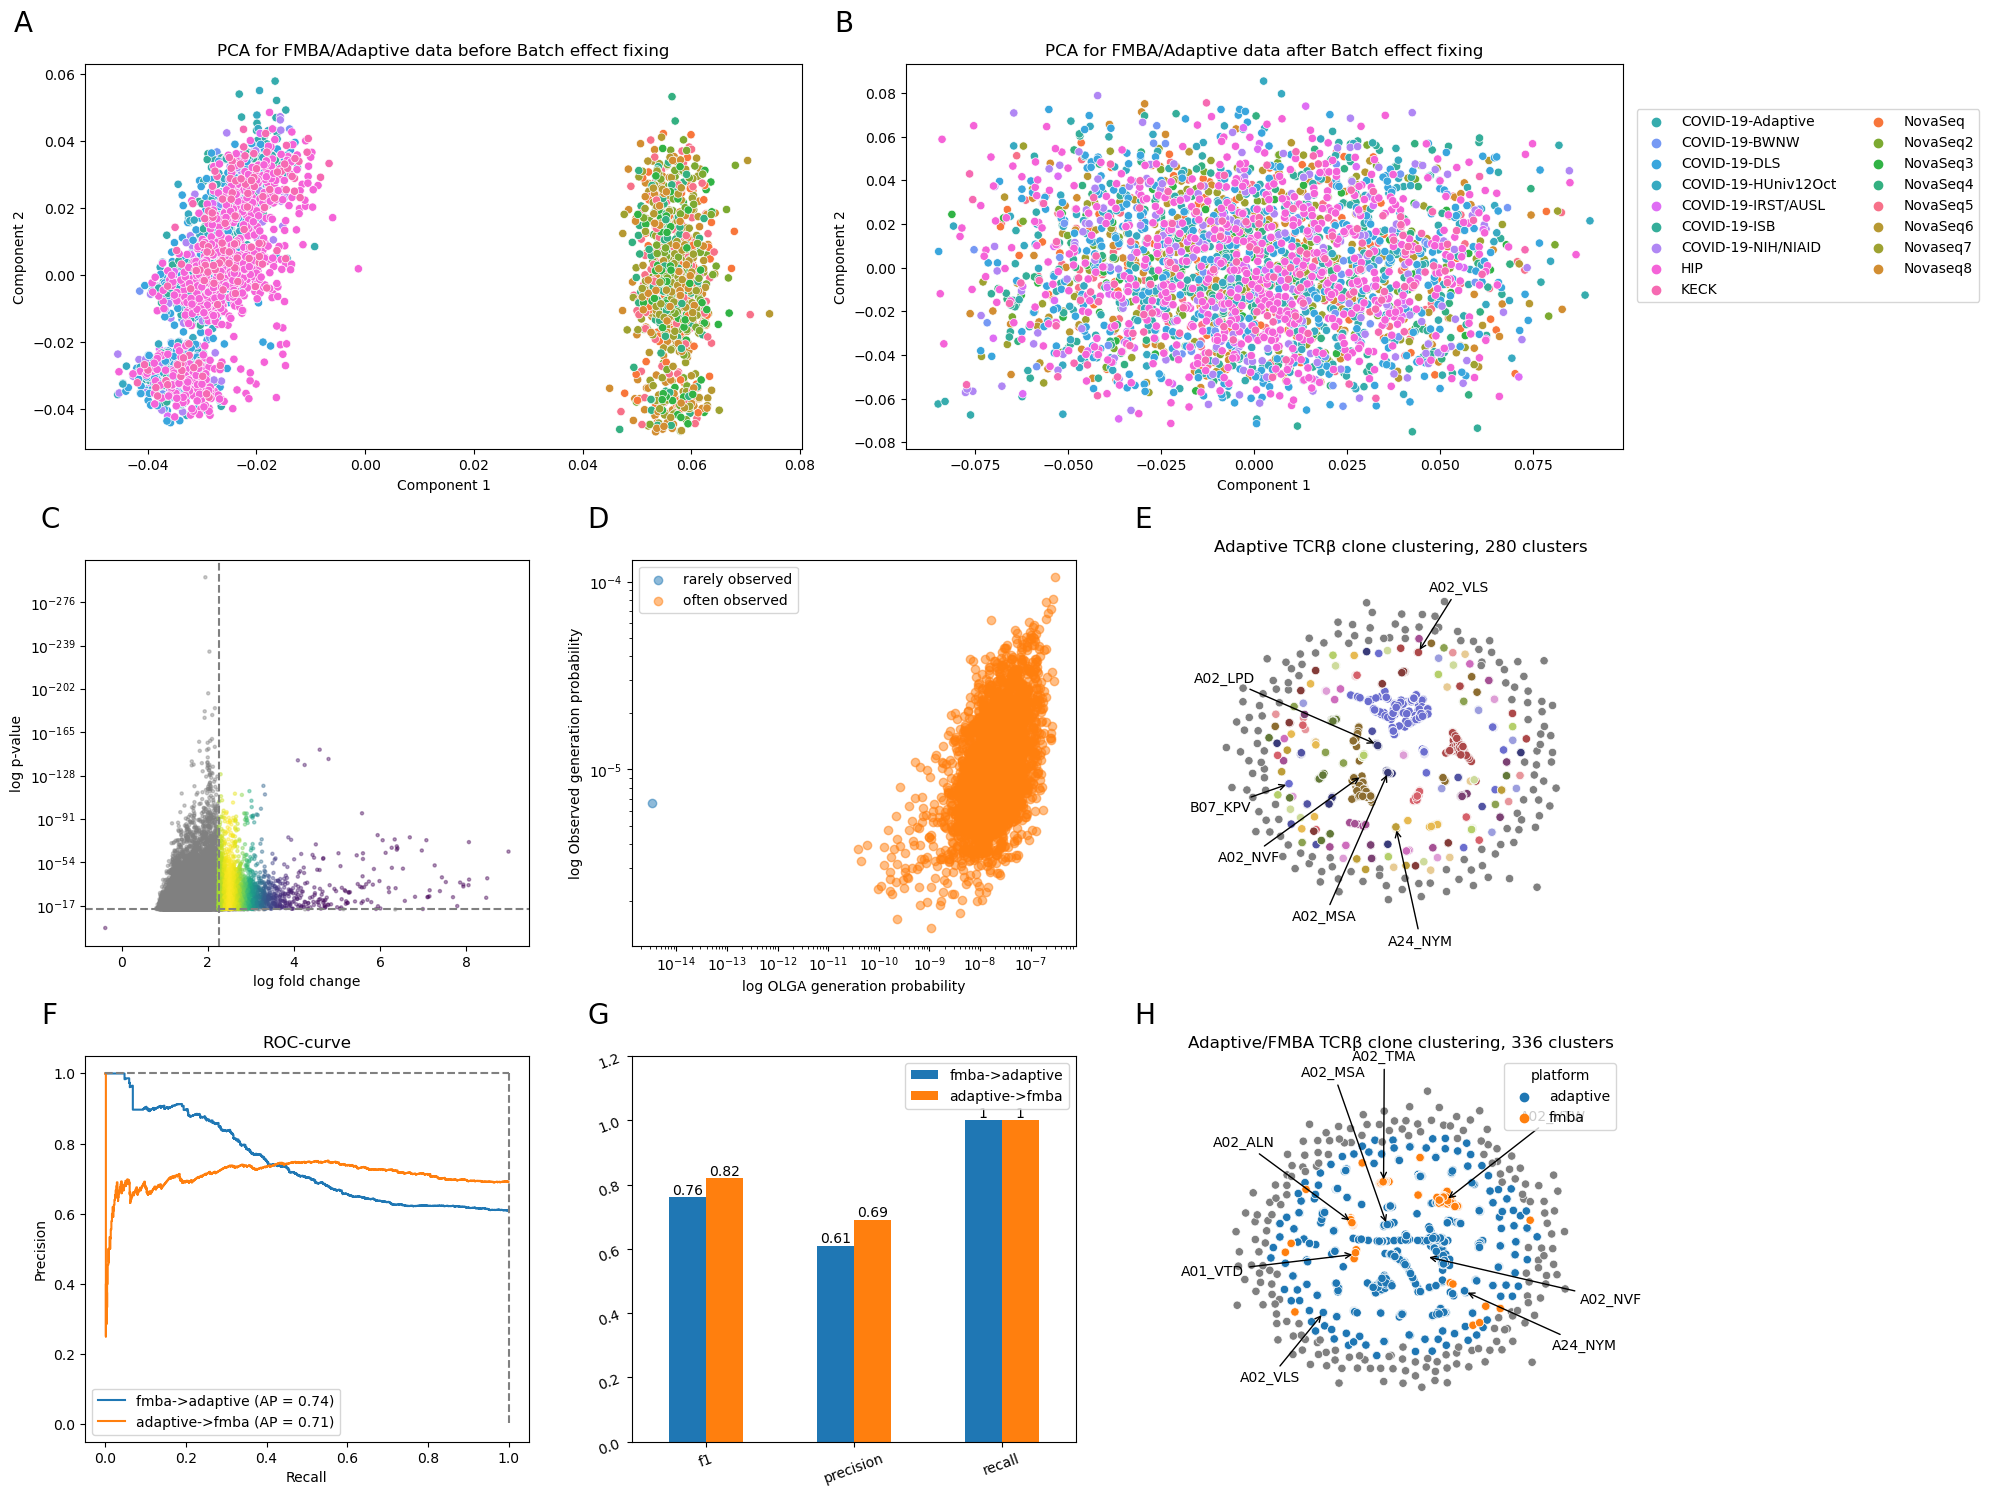

In [56]:
fig = plt.figure(figsize=(20, 15))
gs = GridSpec(nrows=3, 
              ncols=6)
font_size=20
delta_x=-0.1
delta_y=1.14

########################################################
ax0 = fig.add_subplot(gs[0, :3])

plot_usage_matrix_pca(norm_um_joint, method=PCA, target='project', ax=ax0)

ax0.legend()
ax0.set_title('PCA for FMBA/Adaptive data before Batch effect fixing')
ax0.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax0.transAxes,
        size=font_size)
ax0.legend([],[], frameon=False)

########################################################
ax1 = fig.add_subplot(gs[0, 3:])

plot_usage_matrix_pca(stand_um_joint, method=PCA, target='project', ax=ax1)

ax1.legend()
ax1.set_title('PCA for FMBA/Adaptive data after Batch effect fixing')
ax1.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)
handles, labels = ax1.get_legend_handles_labels()
pairs = [(x, y) for x, y in zip(handles, labels)]
pairs.sort(key=lambda x: x[1])

leg = ax1.legend([x[0] for x in pairs], [x[1] for x in pairs], ncol=2, bbox_to_anchor=(1.01, 0.9)) 

# sns.move_legend(ax1, "upper right", bbox_to_anchor=(1.15, 1.1))
########################################################

ax3 = fig.add_subplot(gs[1, :2])
plot_volcano(fold_change_data_adaptive, pval_threshold=1e-14, fold_change_threshold=2.25, ax=ax3)
ax3.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)
ax3.set_ylabel('log p-value')

########################################################

ax4 = fig.add_subplot(gs[1, 2:4])
plot_olga_cleanup_data(probas_adaptive, observed_threshold=1e-6, gen_threshold=1e-12, ax=ax4)
ax4.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax4.transAxes,
        size=font_size)

########################################################

ax5 = fig.add_subplot(gs[1, 4:])


plot_clonotype_clustering_with_epitope_labeling(res_adaptive, 
                                                adaptive_cluster_to_epi, 
                                                vdjdb, 
                                                gene='TRB', 
                                                cluster_size_threshold=0, 
                                                dist_to_center=550, 
                                                center_diff_threshold=75,
                                                ax=ax5)
ax5.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)
ax5.set_title(f'Adaptive TCRβ clone clustering, {res_adaptive.cluster.max() + 1} clusters')
ax5.axis('off')
ax5.set_xlim(-650, 650)
ax5.set_ylim(-650, 650)
ax5.legend([],[], frameon=False)

########################################################

ax6 = fig.add_subplot(gs[2, :2])

for key in ['fmba->adaptive', 'adaptive->fmba']:
    PrecisionRecallDisplay.from_estimator(
        all_clfs[key], X_test_data[key], y_test_data[key], name=key, ax=ax6
    )
    # fpr, tpr, _ = roc_curve(y_test_data[key], all_clfs[key].predict_proba(X_test_data[key])[::,1])
    # ax6.plot(fpr,tpr, label=key)

ax6.set_ylabel('Precision')
ax6.set_xlabel('Recall')
ax6.plot([0, 1], [1, 1], linestyle='dashed', color='grey')
ax6.plot([1, 1], [1, 0], linestyle='dashed', color='grey')
ax6.legend()
ax6.set_title('ROC-curve')
ax6.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)


########################################################

ax2 = fig.add_subplot(gs[2, 2:4])

metrics.T.plot.bar(ax=ax2)
for c in ax2.containers:
    ax2.bar_label(c, label_type='edge')
ax2.set_ylim(0, 1.2)
ax2.tick_params(labelrotation=20)
ax2.text(delta_x, delta_y, 'G',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)
########################################################

ax5 = fig.add_subplot(gs[2, 4:])
plot_clonotype_clustering_with_epitope_labeling(res_joint, 
                                                joint_cluster_to_epi, 
                                                vdjdb, 
                                                gene='TRB',
                                                color_by='platform',
                                                cluster_size_threshold=0, 
                                                dist_to_center=600, 
                                                center_diff_threshold=75,
                                                ax=ax5)
ax5.set_xlim(-700, 700)
ax5.set_ylim(-700, 700)
ax5.text(delta_x, delta_y, 'H',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)
ax5.axis('off')
ax5.set_title(f'Adaptive/FMBA TCRβ clone clustering, {res_joint.cluster.max() + 1} clusters')

########################################################

plt.tight_layout()
plt.savefig("figures/fig5.svg")
plt.savefig("figures/fig5.pdf")
plt.savefig("figures/fig5.png")
plt.show()
